In [34]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [35]:
rootfolder = '../data/'


Useful function for plot the 2D DCT dictionary

In [36]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [37]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - D @ x

  # support set
  omega = [] 
  
  while np.linalg.norm(r) > tau and len(omega) < L:
    # SWEEP STEP
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (r.T @ dj)**2 / np.linalg.norm(dj)**2

    # find the column of D that matches best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s||
    D_omega = D[:, omega]
    x_w, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)
    for j, w in zip(omega, x_w.flatten()): 
        x[j] = w

    # update the residual
    r = s - D @ x

  return x

Load the image and rescale it in $[0,1]$

In [38]:
img = imread(f'{rootfolder}peppers256.png') / 255
# img = imread(f'{rootfolder}barbara.png') / 255
# img = imread(f'{rootfolder}Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [39]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Percentage of removed pixel

In [40]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [41]:
# create a vector with all the indexes of the image
idx = np.arange(imsz[0] * imsz[1])

# shuffle it and take the target percentage of indexes
idx = np.random.permutation(idx)
idx = idx[:int(perc_of_removed_pixels * imsz[0] * imsz[1])]

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones(imsz)
msk = msk.flatten()
msk[idx] = 0
msk = msk.reshape(imsz)

# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk


Compute the psnr of the noisy input

In [42]:
psnr_noisy = 10 * np.log10(1 / np.mean((img - noisy_img) ** 2))


Text(0.5, 1.0, 'Dead pixels')

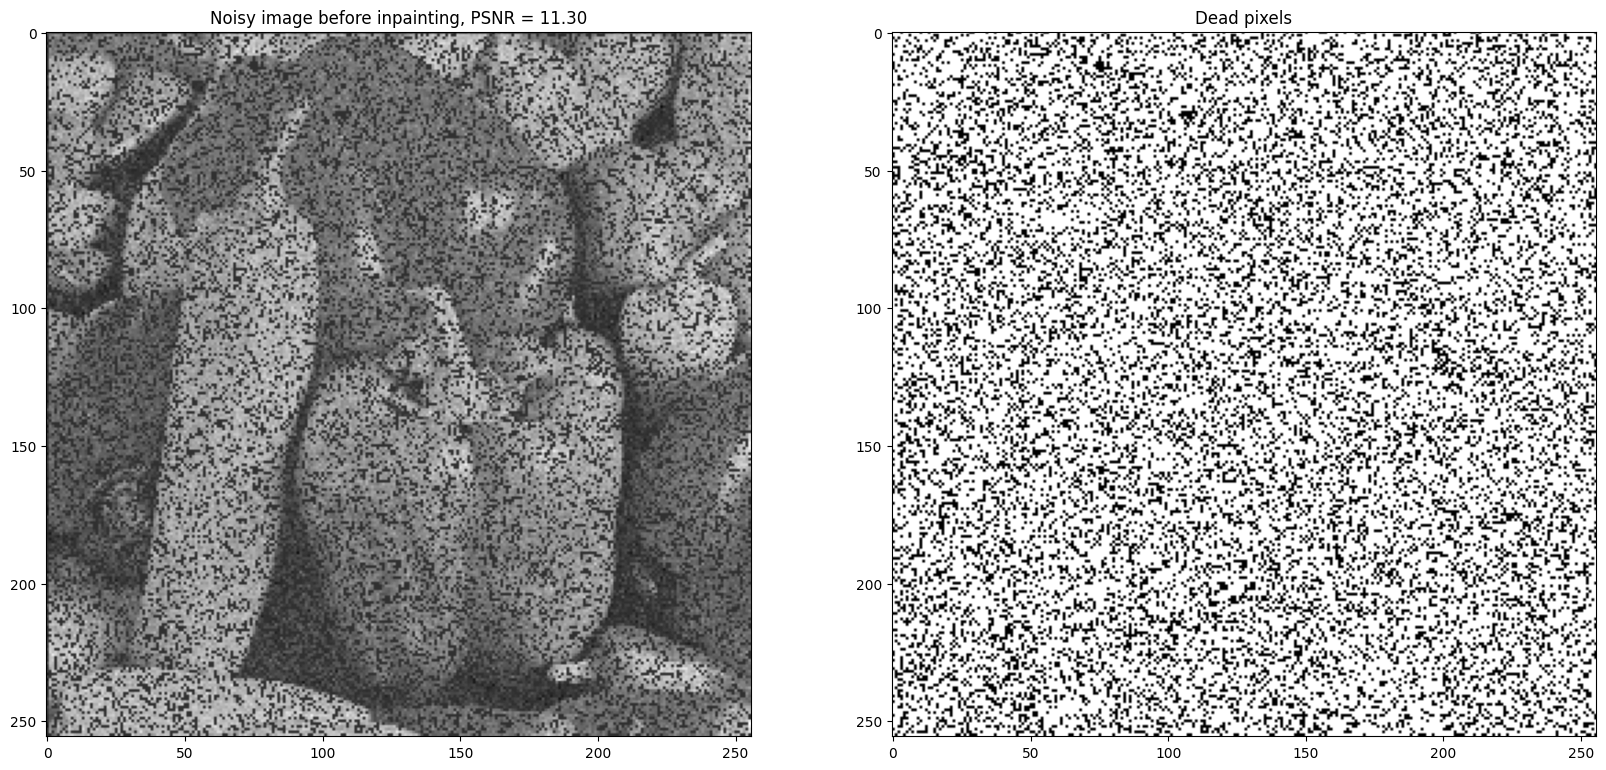

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title(f'Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title(f'Dead pixels')


Load and display the dictionary learned from patches

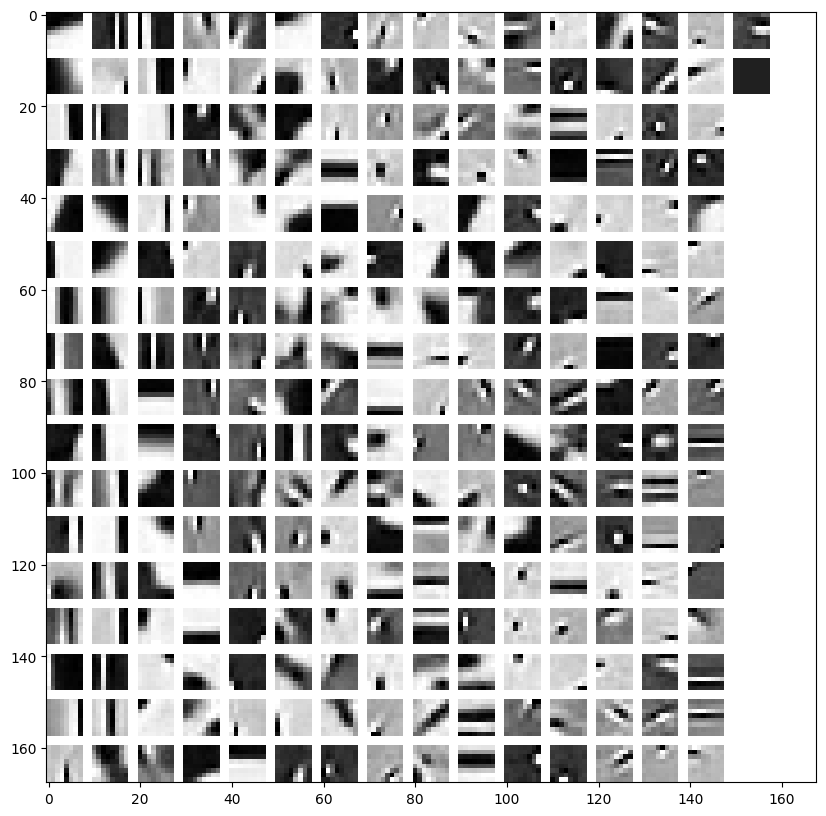

In [44]:
D = loadmat(f'{rootfolder}dict_nat_img.mat')['D']

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
constantAtom = np.ones((M, 1)) / np.sqrt(M)
D = np.hstack((D, constantAtom))

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Inpainting
----------


In [45]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [46]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i + p, j:j + p].flatten()
        
        mean = np.mean(s)
        s-= mean

        # patch extracted from the mask
        m = msk[i:i + p, j:j + p].flatten()

        # design the projection operator over the current patch
        proj = np.diag(m)

        # tau should be proportional to the number of pixels remaining in the patch
        tau = 1.156 * np.sqrt(np.count_nonzero(m))

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        x = OMP(s, proj @ D, L, tau)

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = np.matmul(D, x)
        s_hat += mean

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        img_hat[i:i+p, j:j+p] += s_hat.reshape((p,p))

        # store the weight of the current patch in the weight matrix
        weights[i:i+p, j:j+p] +=1


Normalize the estimated image with the computed weights

In [47]:
img_hat /= weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 15.73')

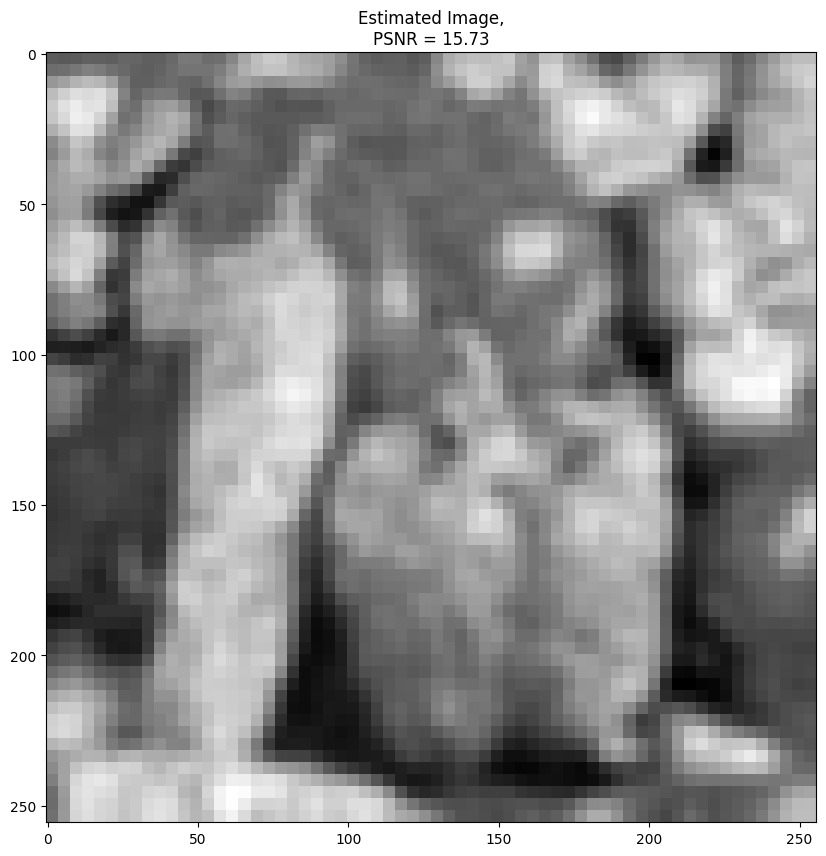

In [48]:
psnr_hat = 10 * np.log10(1 / np.mean((img_hat - img) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
